# Import packages and load data

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from matplotlib import rc
xscaler = MinMaxScaler()

In [2]:
file_path = '../input_data/full_set.csv'
model_output = 'order_disorder'
# import data frame for pre-processing
df = pd.read_csv(file_path)
df.head()

,Sample Name,Polymer Component,Polymer Conc.(mg/ml),Solvent type,Solvent Ratio,Additive type,Amount of additive (mg/ml),Peak Position,FWHM,domain,grain size,afm_domain,O/D,tri
0,I_A_AC,PS-b-PEO,20,Toluene/THF,80/20,Chloronaphthalene,1.00,0.020072,0.003697,31.302630,NaN,33.737303,0,0
1,I_A025,PS-b-PEO,20,Toluene/THF,80/20,Chloronaphthalene,1.25,0.018586,0.003136,33.805848,0.006850,35.151690,0,1
2,I_A050,PS-b-PEO,20,Toluene/THF,80/20,Chloronaphthalene,1.50,0.018385,0.002970,34.176062,0.057600,35.397797,0,1
3,I_A075,PS-b-PEO,20,Toluene/THF,80/20,Chloronaphthalene,1.75,0.018274,0.003451,34.383752,0.073026,34.603726,0,1
4,I_A_100,PS-b-PEO,20,Toluene/THF,80/20,Chloronaphthalene,2.00,0.019837,0.005122,31.674149,0.016718,33.786210,0,1


# Data Pre-processing

In [3]:
%%time
# assign input variables and target variable, eliminates static values from the data set
inputs = df.loc[:, ('Solvent Ratio', 'Amount of additive (mg/ml)')]
target = df['O/D']

# Define the custom mapping dictionary
mapping_dict = {'50/50': 0.5, '60/40': 0.6, '70/30': 0.7, '80/20': 0.8, '90/10': 0.9, '100': 1.0}

# Initializes label encoder
le_solventRatio = LabelEncoder()
le_solventRatio.fit(list(mapping_dict.keys()))
# encode non-numeric type inputs
# inputs['Solvent Ratio_n'] = le_solventRatio.transform(inputs['Solvent Ratio'])
# Map the transformed values to the desired values
inputs['Solvent Ratio_n'] = inputs['Solvent Ratio'].map(mapping_dict)
# remove non-encoded data from dataset 
inputs_n = inputs.drop(['Solvent Ratio'],axis='columns')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(inputs_n,target,
                                                    test_size=0.2,random_state=10)

# Scale the x data for better fitting
xscaler.fit(X_train)
X_train = xscaler.transform(X_train)
X_test = xscaler.transform(X_test)
X_all = xscaler.transform(inputs_n)

CPU times: user 10.1 ms, sys: 3.28 ms, total: 13.4 ms
Wall time: 12.6 ms


# Grid-Search

In [4]:
%%time
# Create an instance of our model
svc = SVC(probability=True)

# Define the hyperparameters to evaluate
param_grid = [{
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 10],
    'degree': [2, 3, 4],
    'coef0': [-1, 0, 1],
    'shrinking': [True, False],
    'cache_size': [100, 500, 1000]
}]

grid_search = GridSearchCV(svc, param_grid, cv=5, n_jobs=-1, scoring='f1', verbose=False)

grid_search.fit(X_train, y_train)

CPU times: user 2.13 s, sys: 181 ms, total: 2.31 s
Wall time: 4.94 s


GridSearchCV(cv=5, estimator=SVC(probability=True), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100],
                          'cache_size': [100, 500, 1000], 'coef0': [-1, 0, 1],
                          'degree': [2, 3, 4], 'gamma': [0.01, 0.1, 1, 10],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                          'shrinking': [True, False]}],
             scoring='f1', verbose=False)

In [5]:
# Optional, print the best performing model score and associated parameters
print(grid_search.best_params_)
print(grid_search.best_score_)
# print(X_test)
# predic_set = inputs_n
# print(predic_set)
# Create an instance of the best performing model & train
best = grid_search.best_estimator_
svceval = best.predict(X_test)
svctrain = best.predict(X_train)
# print(svctrain)
# Create an array for x values
x_len = len(svceval)
actual_x = np.arange(1, x_len+1)

# Define the output path for figures
output_path = f'./final_figs/{model_output}/'

{'C': 10, 'cache_size': 100, 'coef0': -1, 'degree': 2, 'gamma': 1, 'kernel': 'sigmoid', 'shrinking': True}
0.9802439024390244


In [6]:
predic_set = inputs_n
svc_fullset = best.predict(predic_set)

/home/bradley/anaconda3/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


In [6]:
from sklearn.metrics import f1_score

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Make predictions using the best model
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Calculate the F1 score
f1_train = f1_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred_test)

print("Training F1 Score:", f1_train)
print("Testing F1 Score:", f1_test)

Training F1 Score: 0.9852216748768473
Testing F1 Score: 1.0


In [7]:
from sklearn.metrics import roc_auc_score

# Predict probabilities for test data
y_pred_proba_train = best.predict_proba(X_train)[:, 1]
y_pred_proba_test = best.predict_proba(X_test)[:, 1]

# Calculate AUC score
auc_score_train = roc_auc_score(y_train, y_pred_proba_train)
auc_score_test = roc_auc_score(y_test, y_pred_proba_test)

print("Training AUC Score:", auc_score_train)
print("Testing AUC Score:", auc_score_test)

Training AUC Score: 0.997
Testing AUC Score: 1.0


In [8]:
# Convert cv_results_ to DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

file_name = 'grid_search_results.csv'
# Save results to CSV file
results_df.to_csv(output_path + file_name, index=False)

In [9]:
# predic_set = inputs_n
svc_fullset = best.predict(X_all)

In [10]:
# Calculate the F1 score
f1_full = f1_score(target, svc_fullset)

print("Training F1 Score:", f1_full)

Training F1 Score: 0.9880478087649402


In [11]:
# Make predictions using the best model
y_pred_proba_full = best.predict_proba(X_all)[:, 1]

# Calculate the F1 score
auc_score_full = roc_auc_score(target, y_pred_proba_full)

print("Training F1 Score:", auc_score_full)

Training F1 Score: 0.9981389578163773


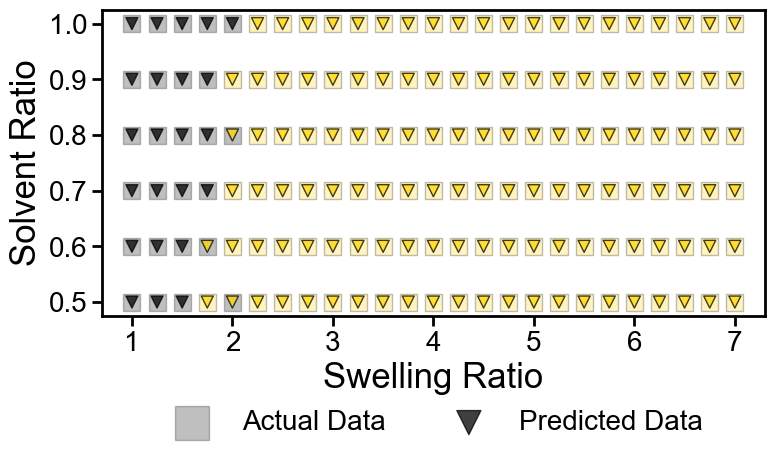

In [16]:
# Assuming your actual and predicted data are pandas DataFrames with columns 'input1', 'input2', and 'class'
from matplotlib.ticker import MultipleLocator
fig_title = f'{model_output}_classification_scatter.png'


%matplotlib inline
rc('text', usetex=False)
rc('mathtext', fontset='cm')
rc('xtick', labelsize=20)   
rc('xtick.major', size=7)  
rc('xtick.minor', size=4)
rc('xtick.major', width=2)
rc('xtick.minor', width=2)
rc('ytick.major', width=2)
rc('ytick.minor', width=2)
rc('ytick', labelsize=20)
rc('ytick.major', size=7)
rc('ytick.minor', size=4)
rc('axes', labelsize=25) 
rc('axes', linewidth=2) 
rc('font',family='sans serif')
rc('font', style='normal')
rc('font', weight='500')
rc('font', size='15')
rc('axes', labelweight='500')
rc('axes.spines', **{'right':True, 'top':True}) 
plt.rcParams['font.family'] = 'Arial'

#This sets the size of the entire image
fig,ax = plt.subplots(figsize=(8,5))
# Define marker colors and edgecolors based on class
actual_edge_colors = ['black' if c == 0 else 'gold' for c in target]
predicted_edge_colors = ['black' if c == 0 else 'gold' for c in svc_fullset]
#fig = plt.figure()
#ax = plt.subplot(111)
# Plotting
ax.scatter(inputs['Amount of additive (mg/ml)'], 
            inputs['Solvent Ratio_n'], marker='s', color='black', alpha = 0.25,
            label='Actual Data', facecolor=actual_edge_colors, s=150)
ax.scatter(inputs['Amount of additive (mg/ml)'], 
            inputs['Solvent Ratio_n'], marker='v', color='black', alpha = 0.75,
            label='Predicted Data', facecolor=predicted_edge_colors, s=75)

plt.xlabel('Swelling Ratio', fontsize='25')
plt.ylabel('Solvent Ratio', fontsize='25')
# Set y-axis major locator to MultipleLocator with base 0.1
plt.gca().yaxis.set_major_locator(MultipleLocator(0.1))

# Shrink current axis by 20%
box = ax.get_position()

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.225),
          fancybox=True, shadow=True, ncol=5, fontsize='20', markerscale=2, frameon=False)
# ax.legend()
plt.tight_layout()
plt.savefig(output_path + fig_title, dpi=1500, format='png')
plt.show()

In [26]:
from sklearn.metrics import confusion_matrix

# Predict labels for the test set
y_pred = best.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(target, svc_fullset)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 23   3]
 [  0 124]]


In [9]:
from joblib import dump, load

dump(best, 'svc_order_disorder.joblib')

['svc_order_disorder.joblib']